In [9]:
import numpy as np
import import_ipynb
#import numpy.linalg as LA
#import LMM as lmm
import random
import time
import os
import pandas as pd
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import Image
import scanpy as sc
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.patches as mpatches
from statsmodels.graphics.api import abline_plot
import seaborn as sns
import umap
from numpy import eye, asarray, dot, sum, diag
from numpy.linalg import svd

import statsmodels.formula.api as smf
import pandas


np.random.seed(10)

def get_binary_covariate(covariate, covariate_level, data):
    covariate_list = np.zeros((data.obs.shape[0]))
    for i in range(data.obs.shape[0]):
        ### select the ith element of 
        if data.obs[[covariate]].squeeze()[i] == covariate_level:
            covariate_list[i] = 1
    return covariate_list




def varimax(Phi, gamma = 1.0, q = 100, tol = 1e-6):
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    Lambda = dot(Phi, R)

    return {'rotloadings':Lambda, 'rotmat':R}



def plot_pca(pca_scores, pca, num_components_to_plot, title='PCA of the data matrix'):
    
    for i in range(1, num_components_to_plot):
        ## color PCA based on strain
        plt.figure()
        plt.scatter(pca_scores[:,0], pca_scores[:,i], c=strain_color, s=1) 
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.title(title)
        plt.legend(handles=[mpatches.Patch(color='springgreen', label='LEW'),
                            mpatches.Patch(color='hotpink', label='DA')])
        plt.show()

        ## color PCA based on cluster
        plt.figure()
        plt.scatter(pca_scores[:,0], pca_scores[:,i], c=c, s=1)
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.title(title)
        plt.show()

        ###  ## color PCA based on sample
        plt.figure()
        plt.scatter(pca_scores[:,0], pca_scores[:,i], c=sample_color, s=1)
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.legend(handles=[mpatches.Patch(color='palegreen', label='LEW_01'),
                            mpatches.Patch(color='forestgreen', label='LEW_02'),
                            mpatches.Patch(color='pink', label='DA_01'),
                            mpatches.Patch(color='orchid', label='DA_02')], loc='best')
        plt.show()


    # plot the variance explained by each PC
    plt.figure()
    plt.plot(pca.explained_variance_ratio_)
    plt.title('Variance explained by each PC')
    plt.xlabel('PC')
    plt.ylabel('Variance explained')
    plt.show()


def plot_umap(pca_scores, pca , title='UMAP of the PC components of the gene expression matrix'):

    ### apply UMAP to teh PCA components
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(pca_scores)
    print('embedding shape: ', embedding.shape)
    
    ### plot the UMAP embedding
    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1], c=strain_color, s=1)
    plt.title(title)
    plt.legend(handles=[mpatches.Patch(color='springgreen', label='LEW'),
                        mpatches.Patch(color='hotpink', label='DA')])
    plt.show()

    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1], c=sample_color, s=1)
    plt.title(title)
    plt.legend(handles=[mpatches.Patch(color='palegreen', label='LEW_01'),
            mpatches.Patch(color='forestgreen', label='LEW_02'),
            mpatches.Patch(color='pink', label='DA_01'),
            mpatches.Patch(color='orchid', label='DA_02')], loc='best')
    plt.show()

    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1], c=c, s=1)
    plt.title(title)
    plt.show()



#### generating the list of colors for clusters
colors = plt.cm.rainbow(np.linspace(0, 1, len(set(y_cluster)))) ### set the color for each cluster
my_color = {}
### define a dictionary to map the cluster number to the color
list_levels = list(set(y_cluster))
for i in range(len(set(list_levels))):
    my_color[list_levels[i]] = colors[i]
### generate a list containing the corresponding color for each cluster
c = [my_color[y_cluster[i]] for i in range(len(y_cluster))]


### generating the list of colors for samples
my_color = {'LEW_01': 'palegreen', 'LEW_02':'forestgreen', 'DA_01':'pink', 'DA_02':'orchid'}
### generate a list containing the corresponding color for each sample
sample_color = [my_color[y_sample[i]] for i in range(len(y_sample))]

my_color = {'LEW': 'springgreen', 'DA':'hotpink'}
strain_color = [my_color[y_strain_str[i]] for i in range(len(y_strain_str))]

### applying PCA to the data matrix
num_components = 30




In [2]:
#### import the immune subpopulation of the rat samples
data = sc.read('/home/delaram/scLMM/input_data_designMat/inputdata_rat_set1_countData_2.h5ad') ## attributes removed
data.var_names_make_unique()
# a.obs['orig.ident'].head()
### renaming the meta info column names: https://github.com/theislab/scvelo/issues/255
data.__dict__['_raw'].__dict__['_var'] = data.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

data_numpy = data.X.toarray()
cell_sums = np.sum(data_numpy,axis=1) # row sums - library size
gene_sums = np.sum(data_numpy,axis=0) # col sums - sum reads in a gene
gene_vars = np.var(data_numpy, axis=0)
data_numpy = data_numpy[:,gene_sums != 0]

### print head pf the data.obs
print(data.obs.head())
data_sub = data_numpy
strain = data.obs.strain
#### sample metadata
y_cluster =data.obs.cluster 
y_sample = data.obs.sample
y_sample = data.obs[['sample']].squeeze()
y_strain_str = data.obs[['strain']].squeeze()

y_strain = get_binary_covariate('strain', 'DA', data=data)


## working with the rat data
num_cells = data_sub.shape[0]
num_genes = data_sub.shape[1]
num_genes = 5000

#### select num_genes genes based on variance
### calculate the variance for each gene
gene_vars = np.var(data_numpy, axis=0)
### select the top num_genes genes with the highest variance
gene_idx = np.argsort(gene_vars)[::-1][0:num_genes]
### subset the data matrix to the top num_genes genes
data_numpy = data_numpy[:, gene_idx]

#### randomly select num_genes genes
#gene_idx = random.sample(range(0, data_numpy.shape[1]), num_genes)
#data_numpy = data_numpy[:, gene_idx]

y = data_numpy


                          orig.ident  nCount_RNA  nFeature_RNA sample strain  \
DA_01_AAACCTGAGACTTGAA-1           0      3007.0          1244  DA_01     DA   
DA_01_AAACCTGAGCCATCGC-1           0      2176.0           919  DA_01     DA   
DA_01_AAACCTGAGGGAAACA-1           0      1978.0           829  DA_01     DA   
DA_01_AAACCTGCACCCATTC-1           0      2702.0          1104  DA_01     DA   
DA_01_AAACCTGCATGCATGT-1           0      2664.0          1061  DA_01     DA   

                         cluster           refined_cell_ID  
DA_01_AAACCTGAGACTTGAA-1       5  DA_01_AAACCTGAGACTTGAA-1  
DA_01_AAACCTGAGCCATCGC-1       9  DA_01_AAACCTGAGCCATCGC-1  
DA_01_AAACCTGAGGGAAACA-1       2  DA_01_AAACCTGAGGGAAACA-1  
DA_01_AAACCTGCACCCATTC-1      11  DA_01_AAACCTGCACCCATTC-1  
DA_01_AAACCTGCATGCATGT-1       5  DA_01_AAACCTGCATGCATGT-1  


In [26]:
# create a one hot encoded array of the y_cluster
y_cluster_int = np.array(y_cluster, dtype=int) ## convert the y_cluster to a numpy array of integers
encoded_array = np.zeros((y_cluster_int.size, y_cluster_int.max()+1), dtype=int) #creating a 2D array filled with 0's
encoded_array[np.arange(y_cluster_int.size),y_cluster_int] = 1  #replacing 0 with a 1 at the index of the original array

## calculate the column sums of the encoded array
col_sums = np.sum(encoded_array, axis=0)
## get the number of unique clusters in y_cluster
num_clusters = len(np.unique(y_cluster))

print(num_clusters)
print(len(col_sums)) ## should be equal to the number of unique clusters
print(col_sums)

## remove the last column of the encoded array - x needs to be full rank
encoded_array = encoded_array[:,0:num_clusters-1] # why isn't this needed????

17
17
[4989 4212 2606 2091 1740 1150 1124  984  977  713  518  517  446  410
  265  167  127]


In [27]:
#### Design matrix : Intercept + cell-types + strain
### the goal is to keep the biological variation of interest and use the residual as a surrogate for technical variation
x = np.column_stack((encoded_array, y_strain))
x = sm.add_constant(x) ## adding the intercept
print(x[0:3,:])
print(x.shape)

[[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(23036, 18)


In [28]:
### fit a poisson regression model to each gene and save the results

num_vars = x.shape[1]

### make an empty array to store the p-values and coefficients
pvalue = []
coefficient = []
yhat = []
tvalues = []
resid_pearson = []
resid_deviance = []
resid_response = []
resid_working = []
fittedvalues = []
nobs = []
models = []

pearson_chi2 = []
deviance = []
null_deviance = []

### time the fitting process
start_time = time.time()

for i in range(len(y[0])):
    y_a_gene = y[:, i]
    model = sm.GLM(y_a_gene, x, family=sm.families.Poisson())
    result = model.fit()
    #print(result.summary())
    
    #models.append([result])
    #coefficient.append([result.params])
    #pvalue.append([result.pvalues]) ## yhat == fittedvalue == mu
    #yhat.append([result.predict()])
    #fittedvalues.append([result.fittedvalues])

    #nobs.append([result.nobs])
    #tvalues.append([result.tvalues])
    resid_pearson.append([result.resid_pearson])
    resid_deviance.append([result.resid_deviance])
    resid_response.append([result.resid_response])
    #resid_working.append([result.resid_working])
    
    #pearson_chi2.append([result.pearson_chi2])
    #deviance.append([result.deviance])
    #null_deviance.append([result.null_deviance])

end_time = time.time()
print('time to fit the model: ', end_time - start_time)


time to fit the model:  200.16440391540527


(23036, 3)


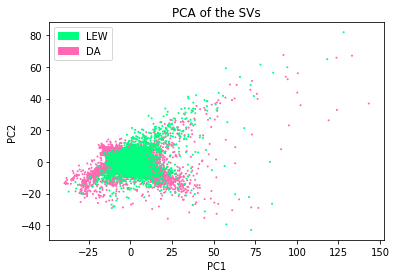

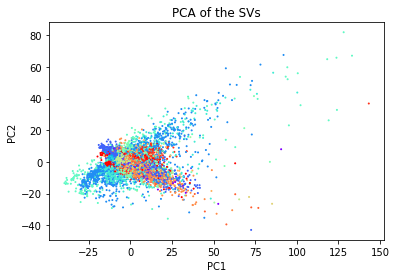

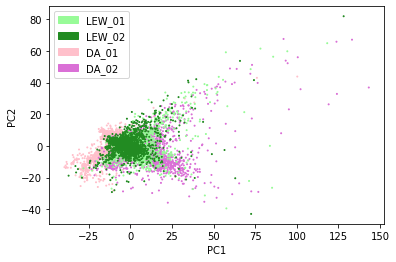

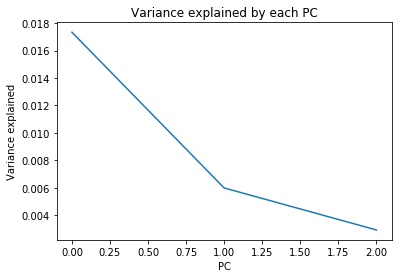

In [29]:
resid_pearson = np.asarray(resid_pearson).reshape(num_genes, num_cells)
resid_response = np.asarray(resid_response).reshape(num_genes, num_cells)

num_components = 3
### apply PCA to the response rediudal with 2 components
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=num_components))])
SVs = pipeline.fit_transform(resid_response.T)
print(SVs.shape)
pca = pipeline.named_steps['pca']

plot_pca(SVs, pca, 3, title='PCA of the SVs')

In [30]:
### define a design matrix based on the SVs and intercept
#### Design matrix : Intercept + Depth + cell-types + strain
x = np.column_stack((np.ones((data.obs.shape[0],1)), SVs))
print(x[0:3,:])
print(x.shape)

[[ 1.          1.03609848 10.85740246 -1.50715874]
 [ 1.         -5.36221184  3.65993912 -1.857926  ]
 [ 1.          0.75952578  3.97420937 -0.93630794]]
(23036, 4)


In [31]:
### fit a poisson regression model to each gene and save the results

num_vars = x.shape[1]

### make an empty array to store the p-values and coefficients
pvalue = []
coefficient = []
yhat = []
tvalues = []
resid_pearson = []
resid_deviance = []
resid_response = []
resid_working = []
fittedvalues = []
nobs = []
models = []

pearson_chi2 = []
deviance = []
null_deviance = []

### time the fitting process
start_time = time.time()

for i in range(len(y[0])):
    y_a_gene = y[:, i]
    model = sm.GLM(y_a_gene, x, family=sm.families.Poisson())
    result = model.fit()
    #print(result.summary())
    
    #models.append([result])
    #coefficient.append([result.params])
    #pvalue.append([result.pvalues]) ## yhat == fittedvalue == mu
    #yhat.append([result.predict()])
    #fittedvalues.append([result.fittedvalues])

    #nobs.append([result.nobs])
    #tvalues.append([result.tvalues])
    resid_pearson.append([result.resid_pearson])
    resid_deviance.append([result.resid_deviance])
    resid_response.append([result.resid_response])
    #resid_working.append([result.resid_working])
    
    #pearson_chi2.append([result.pearson_chi2])
    #deviance.append([result.deviance])
    #null_deviance.append([result.null_deviance])

end_time = time.time()
print('time to fit the model: ', end_time - start_time)


time to fit the model:  118.02114343643188


noise_variance:  0.940463911611775


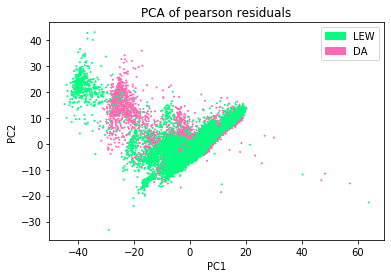

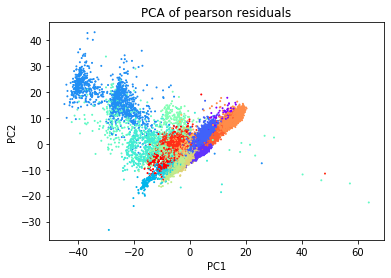

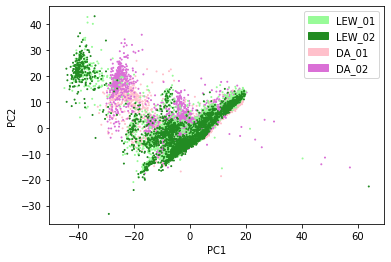

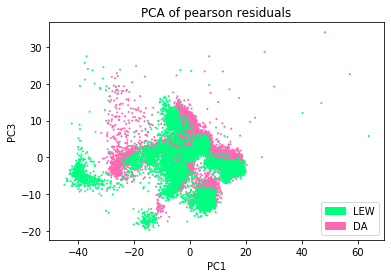

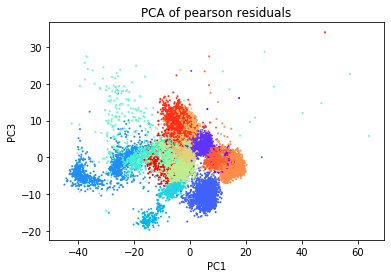

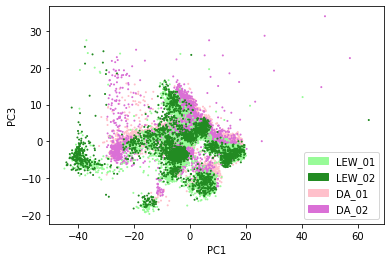

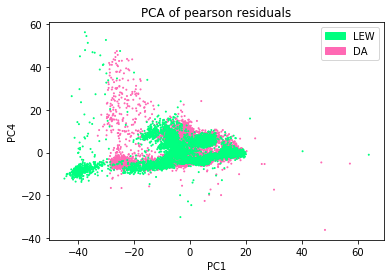

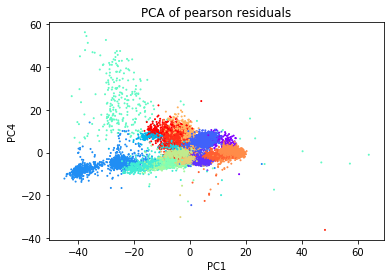

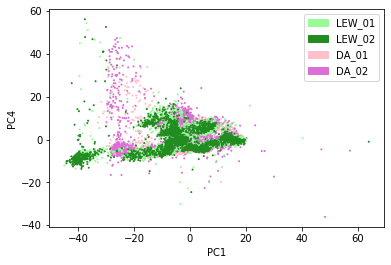

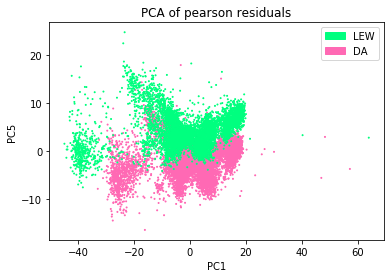

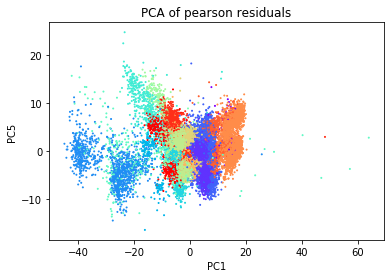

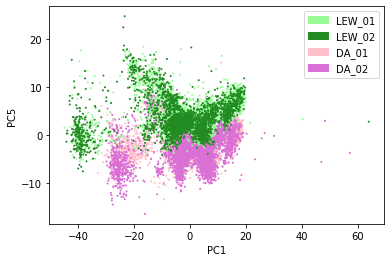

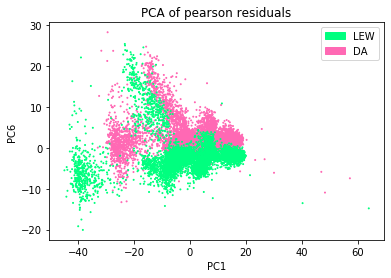

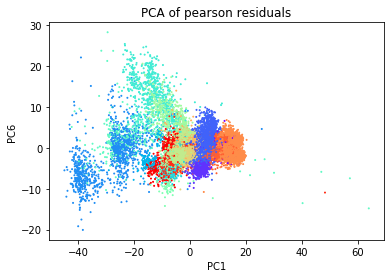

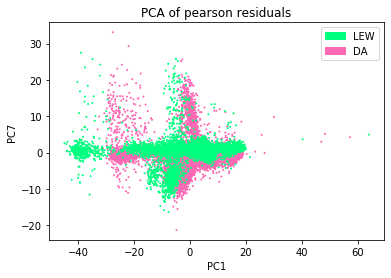

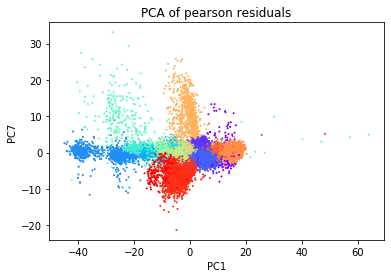

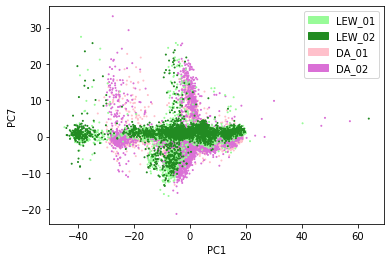

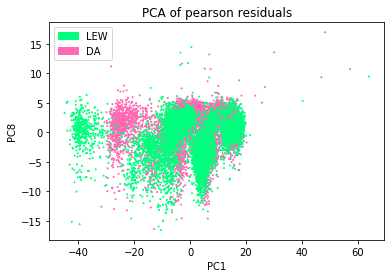

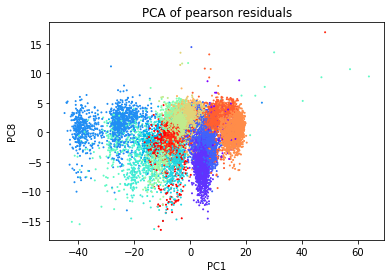

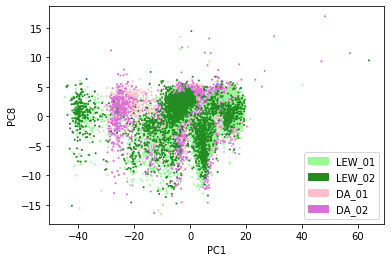

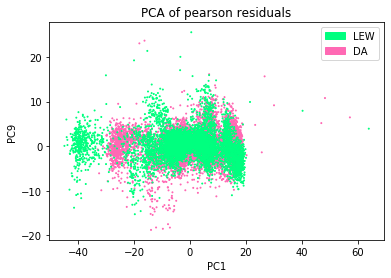

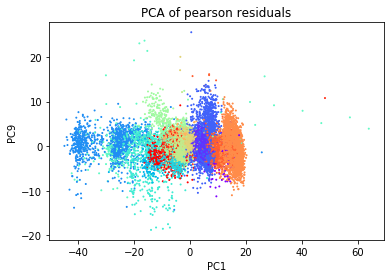

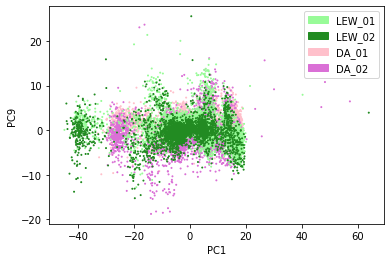

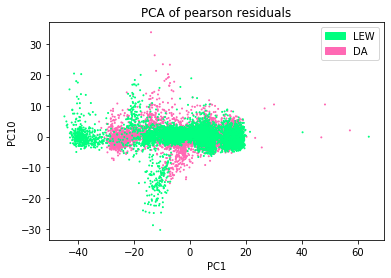

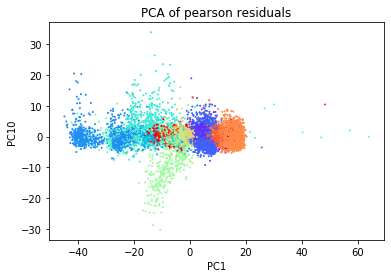

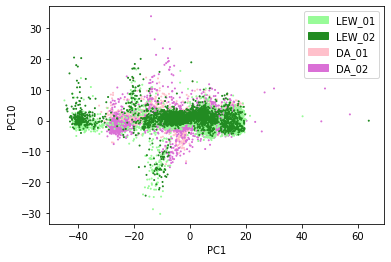

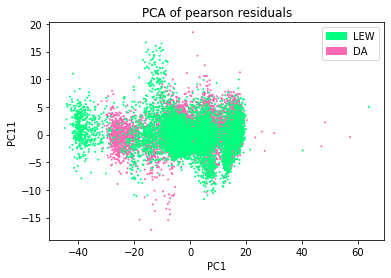

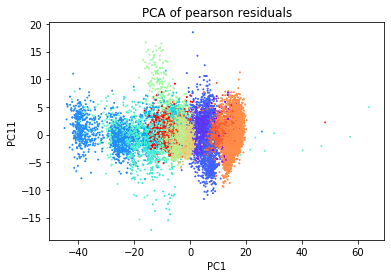

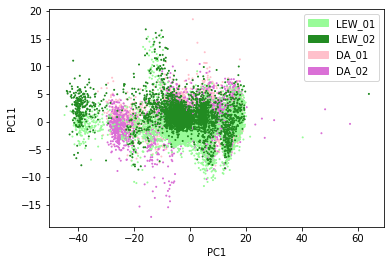

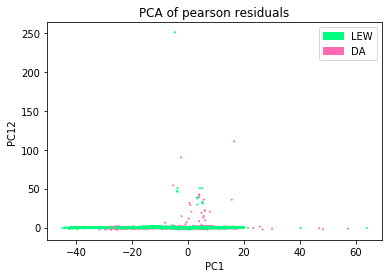

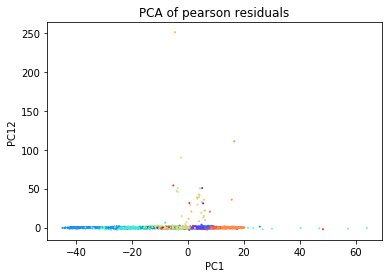

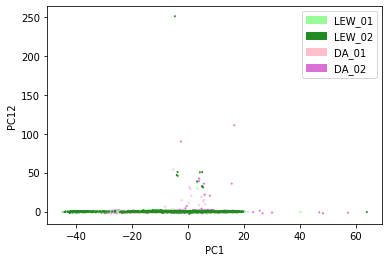

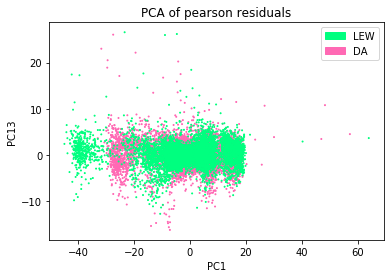

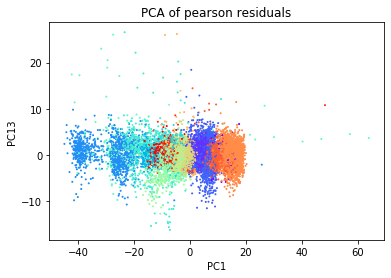

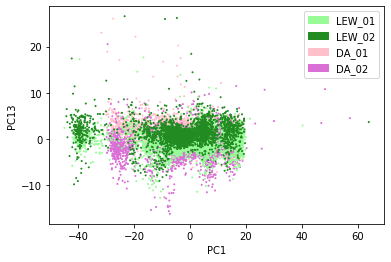

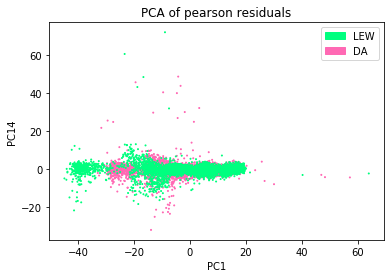

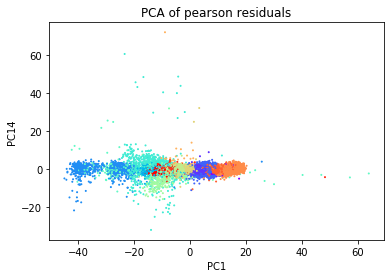

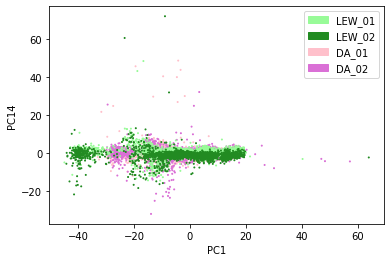

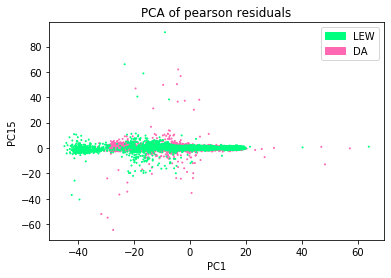

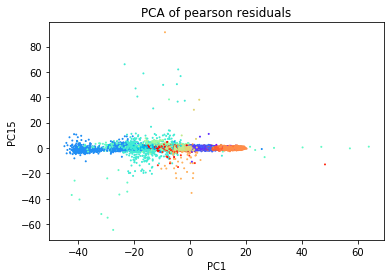

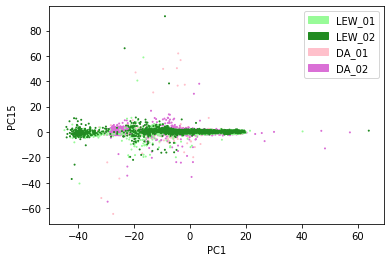

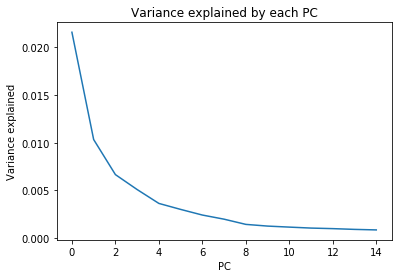

embedding shape:  (23036, 2)


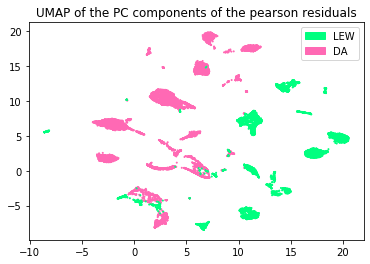

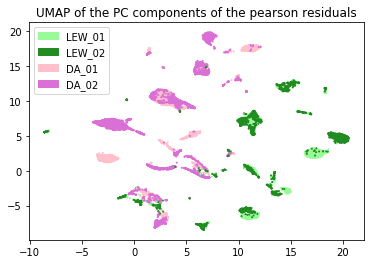

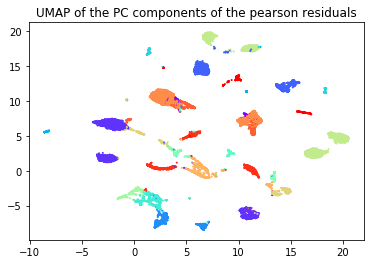

In [17]:
### applying PCA to the pearson residuals
resid_pearson = np.asarray(resid_pearson).reshape(num_genes, num_cells)
num_components = 15
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=num_components))])
pca_scores = pipeline.fit_transform(resid_pearson.T)
pca = pipeline.named_steps['pca']
pca_loading = pca.components_

#print('explained variance ratio: ', pca.explained_variance_ratio_)
#print('singular values: ', pca.singular_values_)#
print('noise_variance: ', pca.noise_variance_)

plot_pca(pca_scores, pca, 15, title='PCA of pearson residuals')
plot_umap(pca_scores, pca, title='UMAP of the PC components of the pearson residuals')


loadings_rot shape:  (5000, 15)
rotmat shape:  (15, 15)
pca_scores shape:  (23036, 15)
pca_scores_rot shape:  (23036, 15)


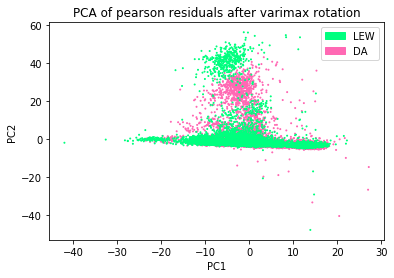

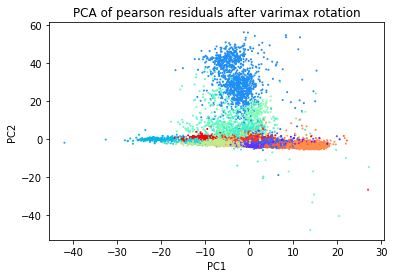

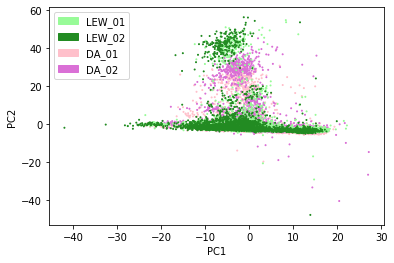

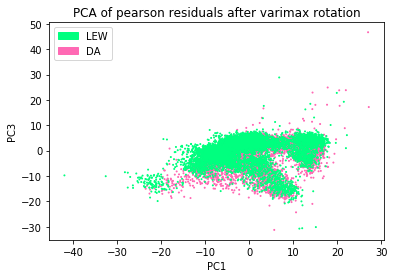

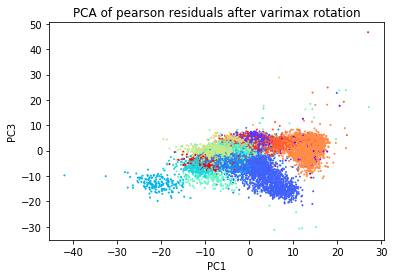

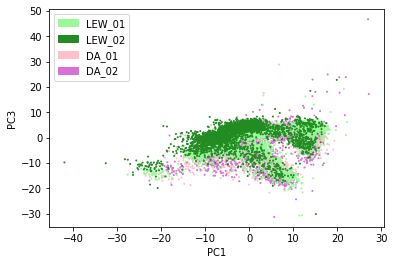

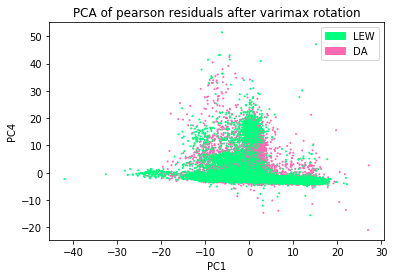

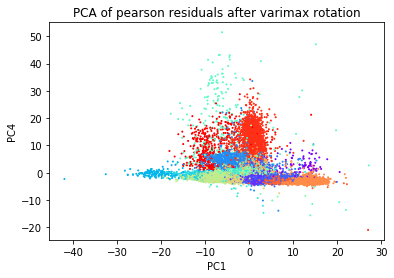

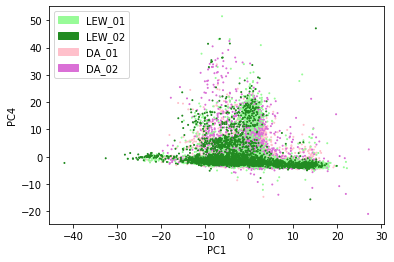

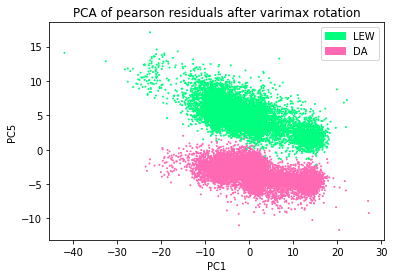

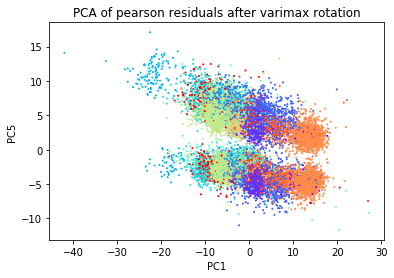

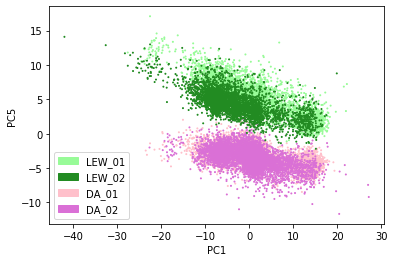

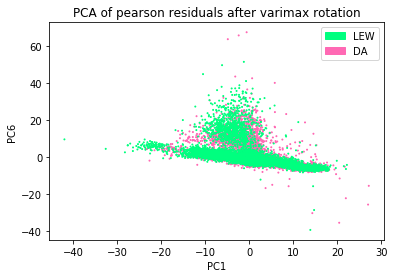

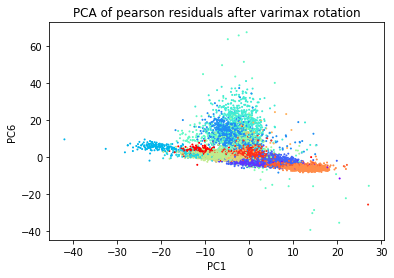

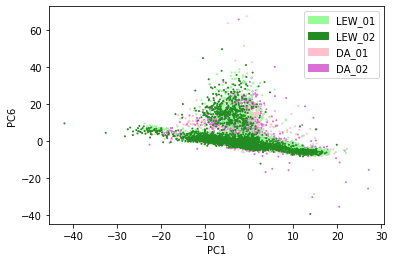

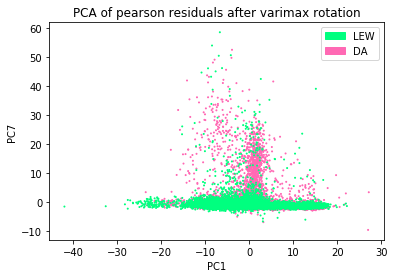

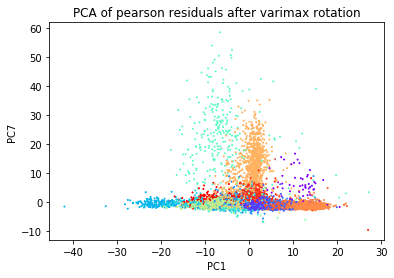

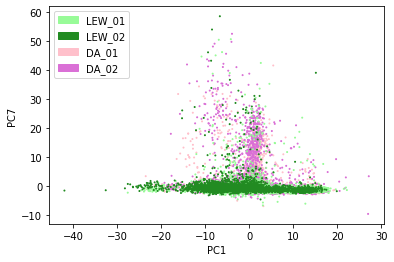

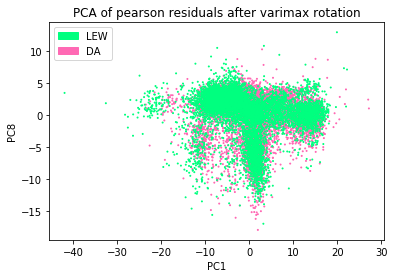

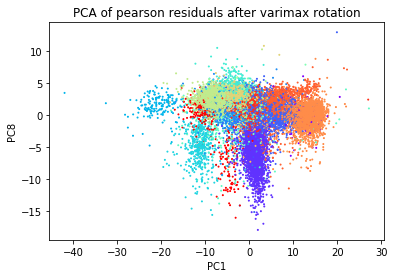

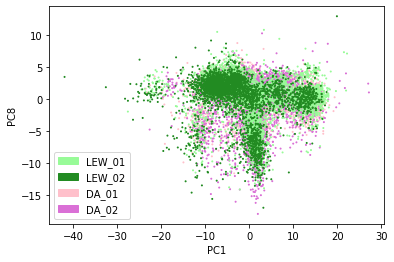

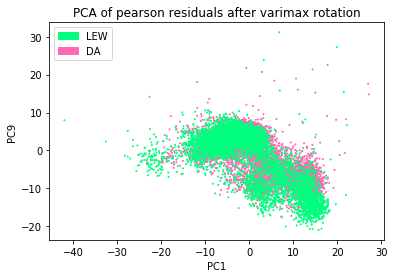

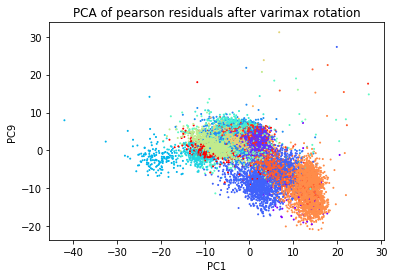

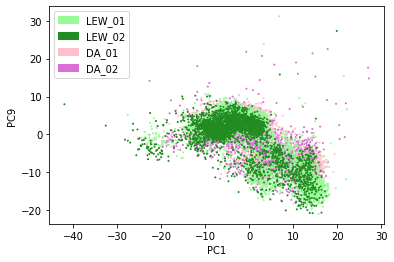

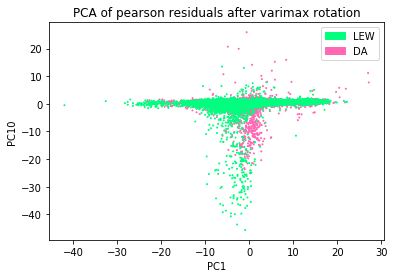

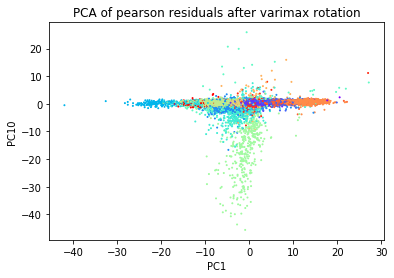

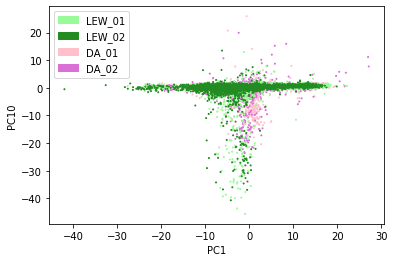

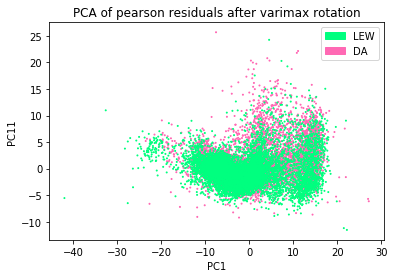

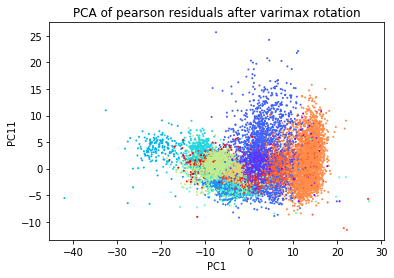

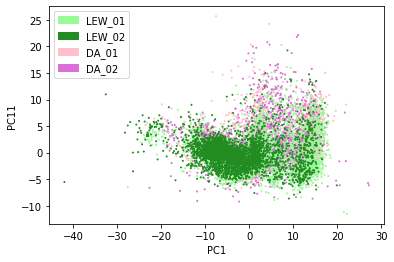

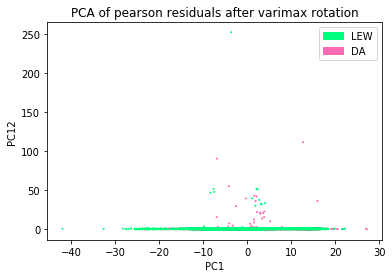

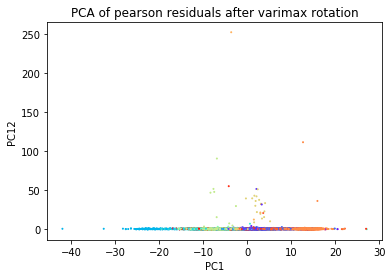

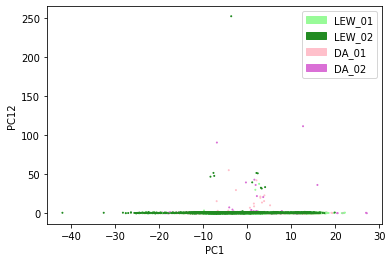

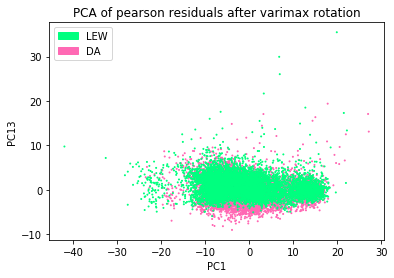

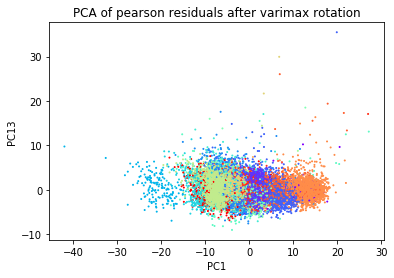

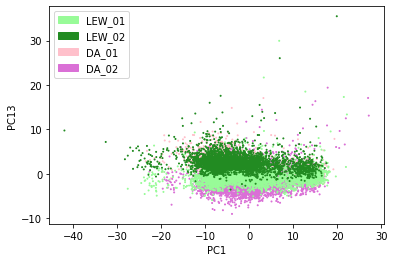

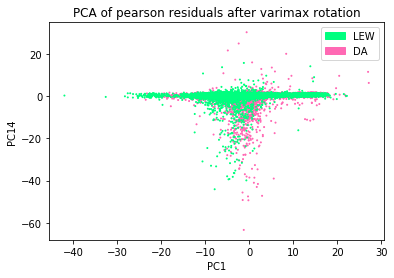

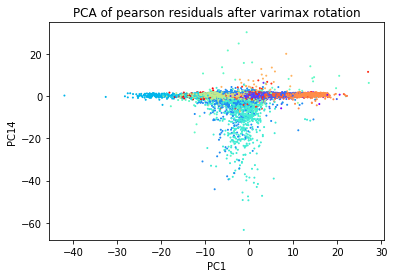

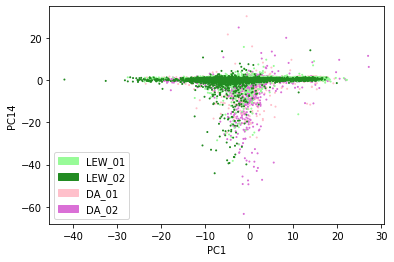

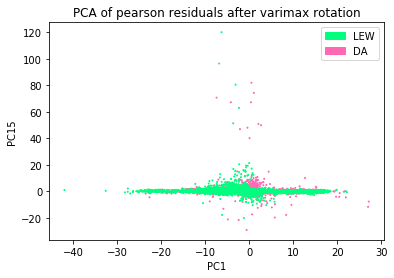

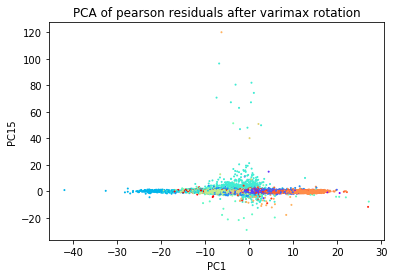

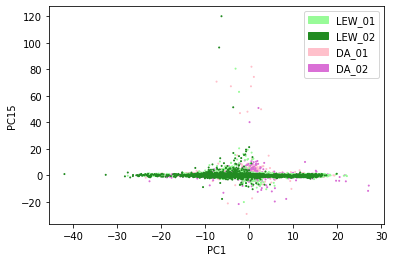

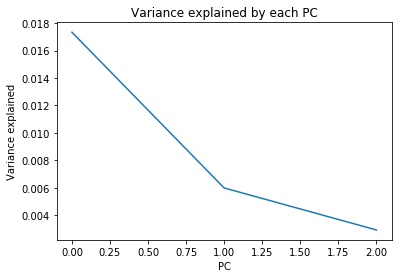

embedding shape:  (23036, 2)


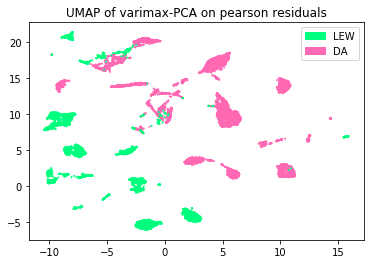

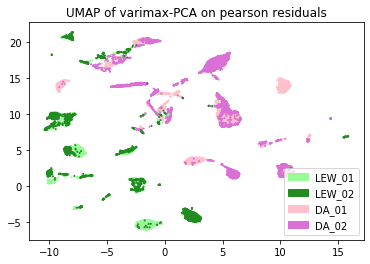

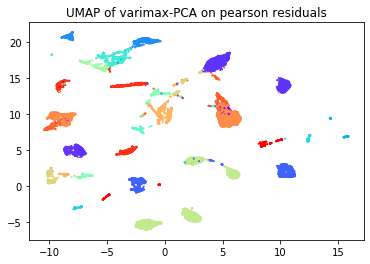

In [32]:
##### First implementation of Varimax rotation ####
## method: scale(original pc scores) %*% rotmat

## apply varimax rotation to the loadings
varimax_rot = varimax(pca_loading.T)
loadings_rot = varimax_rot['rotloadings']
rotmat = varimax_rot['rotmat']
pca_scores_rot = dot(pca_scores, rotmat)

print('loadings_rot shape: ', loadings_rot.shape)
print('rotmat shape: ', rotmat.shape)
print('pca_scores shape: ', pca_scores.shape)
print('pca_scores_rot shape: ', pca_scores_rot.shape)


### plot the rotated scores pca_scores_rot
plot_pca(pca_scores_rot, pca, 15, title='PCA of pearson residuals after varimax rotation')
plot_umap(pca_scores, pca, title='UMAP of varimax-PCA on pearson residuals')

